In [23]:
from math import cos, exp, pi, tanh, sqrt
from scipy.integrate import quad, dblquad
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib.pyplot import figure

def phi(x):
    #we choose what our activation function is going to be here
    return tanh(x)

def normDist(z):
    #this is for the intergral measures
    return (1/sqrt(2*pi))*exp(-(z**2)/2)

def qSSnext(sigmaW, sigmaB, qSSprev):
    #gives us the length of our vector given our parameters and the previous length
    def f(z):
        return (phi(sqrt(qSSprev)*z)**2) * normDist(z)

    range = 10
    intergral = quad(f, -range, range)
    return (sigmaW**2) * intergral[0] + (sigmaB**2)


def qSSstar(sigmaW, sigmaB, qSSprev):
    #works out the limiting length of the vector given the previous length and the parameters
    #we're assume the limit is reached within 30 steps
    qSStemp = qSSprev
    for i in range(30):
        qSStemp = qSSnext(sigmaW, sigmaB, qSStemp)

    return qSStemp

def qAB_next(sigmaW, sigmaB, qAA_prev, qBB_prev, corr_prev):
    #this is for calculating the joint correlation
    #we dont have to assume the vector lengths qAA qBB have reached their limit -
    # but turns out that we will actually just input the limited qAA to make our results input independent

    def u1(z1):
        return sqrt(qAA_prev)*z1

    def u2(z1, z2):
        return sqrt(qBB_prev)*(corr_prev*z1 + sqrt(1- corr_prev**2)*z2)

    def f(z1, z2):
        return phi(u1(z1))*phi(u2(z1, z2))*normDist(z1)*normDist(z2)

    range = 10
    intergral = dblquad(f, -range, range, -range, range)

    return (sigmaW**2) * intergral[0] + (sigmaB**2)


def corr_map(sigmaW, sigmaB, corr_prev):
    #so we get the the new correlation, given a correlation, the only other things
    #that matter are the sigmas, since we just use the convergent length, that only depends on sigmaW sigmaB

    some_random_length = 10 # doesn't make a difference as qSSstar limits to same value
    qSSstar_val = qSSstar(sigmaW, sigmaB, some_random_length)

    q_AB = qAB_next(sigmaW, sigmaB, qSSstar_val, qSSstar_val, corr_prev)

    return (q_AB / qSSstar_val)

#this numpy move lets us apply the correlation map element wise to a vector
corr_map_vec = np.vectorize(corr_map, excluded=['sigmaW', 'sigmaB'])

def corr_map_plot(sigmaW, sigmaB, steps = 0.025, save = False, name = "untitled"):
    figure(figsize=(20, 20), dpi=80)
    x = np.arange(0, 1, steps)
    y = corr_map_vec(sigmaW, sigmaB, x)
    plt.plot (x, y, 'bo')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save == True:
        plt.savefig(name)
    plt.show()

def deriv_cmap(sigmaW, sigmaB, deriv_point=1):
    print("sigmaW = ", sigmaW, "sigmaB = ", sigmaB)
    #looking at (17) in Poole, this turns out to be very similar to the qAB function
    some_random_length = 10 # doesn't make a difference as qSSstar limits to same value
    qSSstar_val = qSSstar(sigmaW, sigmaB, some_random_length)

    def u1(z1):
        return sqrt(qSSstar_val)*z1

    def u2(z1, z2):
        return sqrt(qSSstar_val)*(deriv_point*z1 + sqrt(1- deriv_point**2)*z2)

    def deriv_phi(x0):
        return derivative(phi, x0, dx = 0.01)

    def f(z1, z2):
        return deriv_phi(u1(z1))*deriv_phi(u2(z1, z2))*normDist(z1)*normDist(z2)

    range = 10
    intergral = dblquad(f, -range, range, -range, range)

    return (sigmaW**2) * intergral[0]


print("set up complete")

set up complete


<Figure size 1600x1600 with 0 Axes>

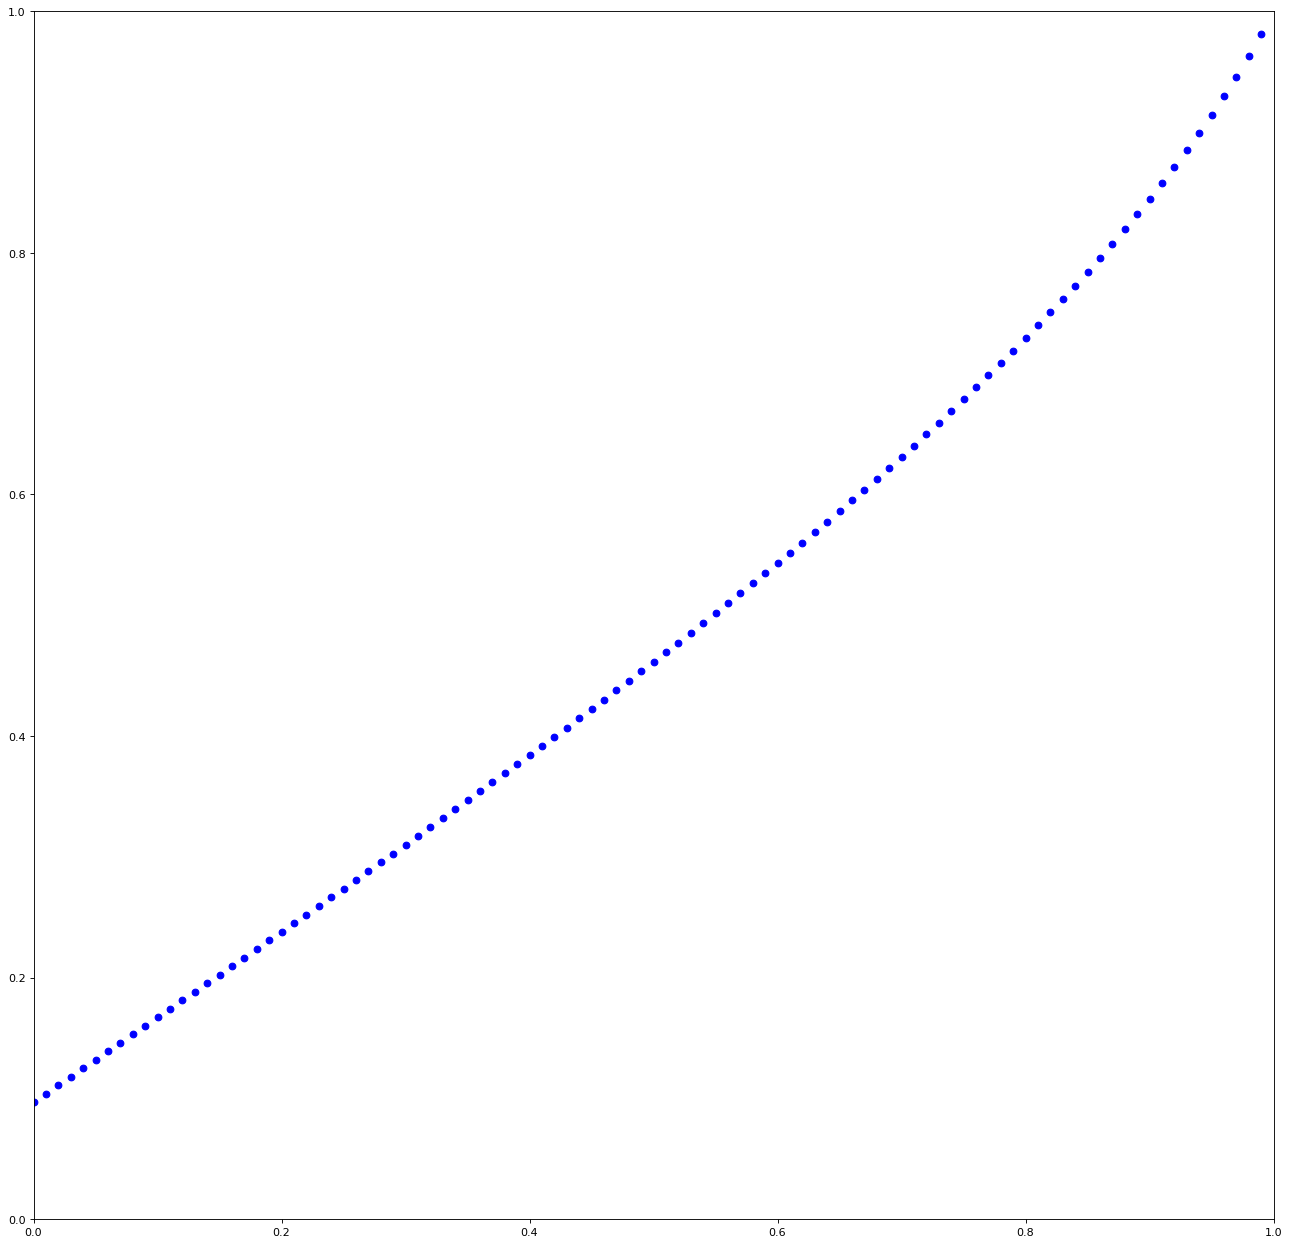

sigmaW =  3.5 sigmaB =  1
Derivative at 1:  1.9975104300523863


In [24]:
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=80)

corr_map_plot(3.5, 1, steps = 0.01, save=True, name = 'corr_curve_sigmaW_3.5__simgaB_1.png')
print("Derivative at 1: ", deriv_cmap(3.5, 1, 1))

<Figure size 1600x1600 with 0 Axes>

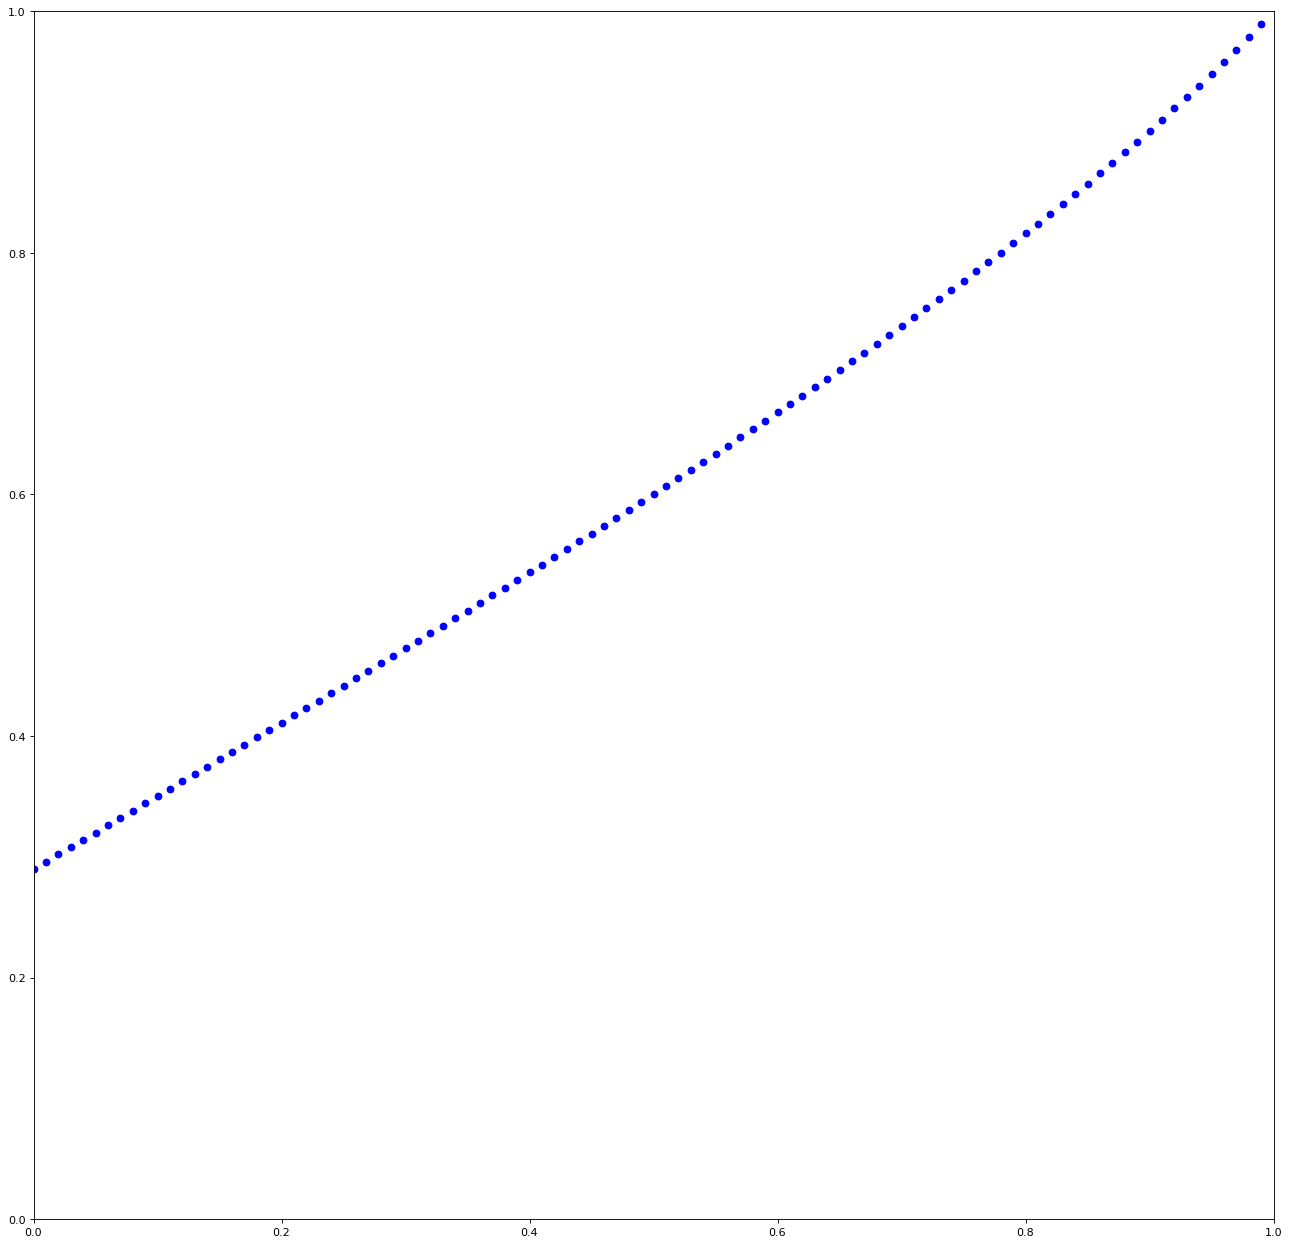

sigmaW =  2 sigmaB =  1
Derivative at 1:  1.0962779549562987


In [25]:
figure(figsize=(20, 20), dpi=80)
corr_map_plot(2, 1, steps = 0.01, save=True, name = 'corr_curve_sigmaW_2__simgaB_1.png')
print("Derivative at 1: ", deriv_cmap(2, 1, 1))